# AlexNet  Demo (2-Class Model)
## By: AmirNejad, PhD.
## Link to Meidum Article XXXX

In [1]:
import datetime
import os,glob
import shutil 
import zipfile,tarfile
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as  sns
from sklearn.metrics import confusion_matrix

#-- tensorflow
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
import tensorflow_addons as tfa
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical,multi_gpu_model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.python.client import  device_lib
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#--
from utils import *

In [2]:
"""
Settings
"""
SEED=42
#---  Plotting Settings:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (8, 6)
DPI=300
save_fig=True
save_path='./results/'
#---  Data  Location Settings:
# path to image folders
path_images='./data/images/ILSVRC/Data/CLS-LOC/'
# path to image class labels
path_labels='./data/'
# locations of the  images
train_directory=os.path.join(path_images,'train')
validation_directory=os.path.join(path_images,'val')
#--- Data Pipeline Settings:
image_height = 227
image_width = 227
EPOCHS = 90
BATCH_SIZE = 32
PATIENCE_FRACTION=1
# if trule only subset of wells are trained, else training on all data 
Subset=True


In [3]:
tf.__version__

'2.3.0'

***
# ImageNet

The official website of ImageNet <a href="http://www.image-net.org/" target="_blank">(link)</a> can provide the images to individuals. However, I received no download link after submitting my request. The easiest way of downloading images is from ImageNet Object Localization Challenge <a href="https://www.kaggle.com/c/imagenet-object-localization-challenge/" target="_blank">(link)</a>.Just follow instruction on the data tab and  download the data using command line.

In [4]:
#  dataframe contains categories of data  
cats=pd.read_csv('categories.csv')

In [5]:
# validation  images  labels
val_labels=pd.read_csv(os.path.join(path_labels,'LOC_val_solution.csv'))
val_labels['labels']=val_labels['PredictionString'].str.split(' ').str[0]
val_labels['ImageId']=val_labels['ImageId']+'.JPEG'

In [6]:
val_labels.head(10)

,ImageId,PredictionString,labels
0,ILSVRC2012_val_00048981.JPEG,n03995372 85 1 499 272,n03995372
1,ILSVRC2012_val_00037956.JPEG,n03481172 131 0 499 254,n03481172
2,ILSVRC2012_val_00026161.JPEG,n02108000 38 0 464 280,n02108000
3,ILSVRC2012_val_00026171.JPEG,n03109150 0 14 216 299,n03109150
4,ILSVRC2012_val_00008726.JPEG,n02119789 255 142 454 329 n02119789 44 21 322 ...,n02119789
5,ILSVRC2012_val_00023881.JPEG,n02666196 0 6 373 498,n02666196
6,ILSVRC2012_val_00011205.JPEG,n02106166 134 90 332 332,n02106166
7,ILSVRC2012_val_00048237.JPEG,n06874185 103 115 154 218 n06874185 346 116 39...,n06874185
8,ILSVRC2012_val_00020622.JPEG,n02643566 37 1 395 327,n02643566
9,ILSVRC2012_val_00045582.JPEG,n04131690 113 143 237 422,n04131690


There are 50  images per class in validation images:

In [7]:
val_labels['labels'].value_counts().min()

50

In [8]:
val_labels['labels'].value_counts().max()

50

### Sample ImageNet Pictures

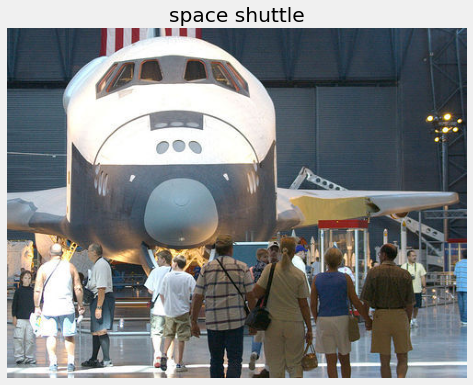

In [9]:
category_index=812
PlotSamples(category_index,path_images,cats,save_fig,str(category_index),save_path,DPI)

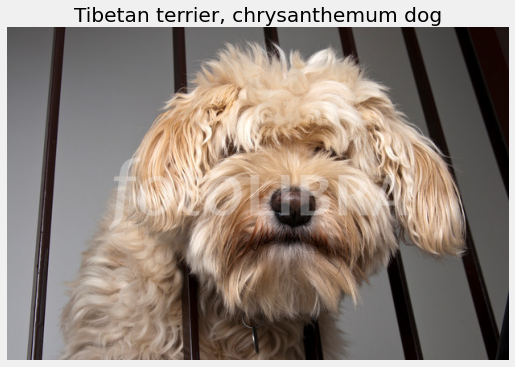

In [10]:
category_index=200
PlotSamples(category_index,path_images,cats,save_fig,str(category_index),save_path,DPI)

In [11]:
# If images are not in sub directores, execute following code to organize images

#ArrangeVals(val_labels,validation_directory)

***
#  Create Data Pipelines



Data pipeline is created by <code> ImageDataGenerator</code>. Each image should be located in a parent directory with appropriate sub-folder (sub-folder name should be the class  label). In order to save time, <code>Subset=True</code> trains the model only on 2 classes.  

In [12]:

if Subset:
    # train only on n images randomly to train our model because of run time
    #Selected_Classes=list(cats['folder_name'].sample(n=2, random_state=SEED).values)
    Selected_Classes=['n03792782','n03095699']

In [13]:
train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=10,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1)
if Subset:
    train_generator = train_datagen.flow_from_directory(train_directory,\
                                                        target_size=(image_height, image_width),\
                                                        color_mode="rgb",\
                                                        batch_size=BATCH_SIZE,\
                                                        seed=SEED,\
                                                        shuffle=True,\
                                                        classes=Selected_Classes,\
                                                        class_mode="categorical")
else:
    train_generator = train_datagen.flow_from_directory(train_directory,\
                                                    target_size=(image_height, image_width),\
                                                    color_mode="rgb",\
                                                    batch_size=BATCH_SIZE,\
                                                    seed=SEED,\
                                                    shuffle=True,\
                                                    class_mode="categorical")

Found 2600 images belonging to 2 classes.


In [14]:
valid_datagen=ImageDataGenerator(rescale=1./255)

if Subset:
    valid_generator = valid_datagen.flow_from_directory(validation_directory,
                                                        target_size=(image_height, image_width),
                                                        color_mode="rgb",
                                                        batch_size=BATCH_SIZE,
                                                        seed=SEED,
                                                        shuffle=True,
                                                        class_mode="categorical",
                                                        classes=Selected_Classes,\
                                                        )
else:
    valid_generator = valid_datagen.flow_from_directory(validation_directory,
                                                        target_size=(image_height, image_width),
                                                        color_mode="rgb",
                                                        batch_size=BATCH_SIZE,
                                                        seed=SEED,
                                                        shuffle=True,
                                                        class_mode="categorical",
                                                        )

Found 100 images belonging to 2 classes.


In [15]:
# test_datagen is used to evaluate the trained AlexNet model (build confusion matrix etc)
# note that the difference between test_datagen  and valid_datagen is just shuffle ==  True

test_datagen=ImageDataGenerator(rescale=1./255)

if Subset:
    test_generator = test_datagen.flow_from_directory(validation_directory,
                                                        target_size=(image_height, image_width),
                                                        color_mode="rgb",
                                                        batch_size=BATCH_SIZE,
                                                        seed=SEED,
                                                        shuffle=False,
                                                        class_mode="categorical",
                                                        classes=Selected_Classes,\
                                                        )
else:
    test_generator = test_datagen.flow_from_directory(validation_directory,
                                                        target_size=(image_height, image_width),
                                                        color_mode="rgb",
                                                        batch_size=BATCH_SIZE,
                                                        seed=SEED,
                                                        shuffle=False,
                                                        class_mode="categorical",
                                                        )

Found 100 images belonging to 2 classes.


***
# AlexNet

![AlexNet](alexnet_original.png)
*Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems. 2012.*

In [16]:
def AlexNet( input_shape, num_classes):
    initializer = tf.keras.initializers.GlorotNormal()
    model = Sequential(name='AlexNet')
    model.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                    padding= 'valid', activation= 'relu',
                    input_shape= input_shape, kernel_initializer= initializer))
    model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))

    model.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= initializer))
    model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None)) 

    model.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= initializer))

    model.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= initializer))

    model.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= initializer))

    model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))

    model.add(Flatten())
    model.add(Dense(4096, activation= 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(4096, activation= 'relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(1000, activation= 'relu'))
    model.add(Dense(num_classes, activation= 'softmax'))

    model.compile(optimizer= tfa.optimizers.SGDW(learning_rate=0.01,momentum=0.9,weight_decay=0.0005,nesterov=True),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [17]:
def train_model(model,valid_generator,train_generator,EPOCHS,BATCH_SIZE,PATIENCE_FRACTION):   
    early_stopping=EarlyStopping(monitor='val_loss',min_delta=0.0005,patience=int(EPOCHS*PATIENCE_FRACTION))
    checkpoint=ModelCheckpoint(filepath='./models/checkpoint_saves/AlexNet_checkpoint_save.h5',\
                               monitor='val_loss',save_weights_only=False)
    callback_list = [early_stopping,checkpoint]
    train_num = train_generator.samples
    valid_num = valid_generator.samples
    history=model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=valid_generator,
                    callbacks=callback_list,
                    verbose=1)
    # laoding the best model 
    checkpoint_model=tf.keras.models.load_model('./models/checkpoint_saves/AlexNet_checkpoint_save.h5')
    return checkpoint_model,history

###  Create Model

In [18]:
#Create The model
num_classes= len(np.unique(train_generator.classes))
model = AlexNet((image_height, image_width, 3), num_classes)
model.summary()

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 256)       8849

###  Train Model

In [19]:
model,history=train_model(model,valid_generator,train_generator,EPOCHS,BATCH_SIZE,PATIENCE_FRACTION)

Epoch 1/90
82/82 [==============================] - 37s 455ms/step - loss: 0.6865 - accuracy: 0.5931 - val_loss: 0.6884 - val_accuracy: 0.5000
Epoch 2/90
82/82 [==============================] - 33s 401ms/step - loss: 0.6496 - accuracy: 0.6292 - val_loss: 0.5285 - val_accuracy: 0.7800
Epoch 3/90
82/82 [==============================] - 33s 397ms/step - loss: 0.5739 - accuracy: 0.7169 - val_loss: 0.5180 - val_accuracy: 0.7700
Epoch 4/90
82/82 [==============================] - 33s 403ms/step - loss: 0.4978 - accuracy: 0.7765 - val_loss: 0.4234 - val_accuracy: 0.8300
Epoch 5/90
82/82 [==============================] - 32s 390ms/step - loss: 0.4077 - accuracy: 0.8262 - val_loss: 0.2864 - val_accuracy: 0.8700
Epoch 6/90
82/82 [==============================] - 33s 406ms/step - loss: 0.3461 - accuracy: 0.8612 - val_loss: 0.2377 - val_accuracy: 0.9100
Epoch 7/90
82/82 [==============================] - 31s 380ms/step - loss: 0.2691 - accuracy: 0.8892 - val_loss: 0.2314 - val_accuracy: 0.9100

Epoch 58/90
82/82 [==============================] - 37s 450ms/step - loss: 0.0827 - accuracy: 0.9719 - val_loss: 0.1696 - val_accuracy: 0.9500
Epoch 59/90
82/82 [==============================] - 35s 432ms/step - loss: 0.0759 - accuracy: 0.9735 - val_loss: 0.2031 - val_accuracy: 0.9300
Epoch 60/90
82/82 [==============================] - 37s 454ms/step - loss: 0.0700 - accuracy: 0.9742 - val_loss: 0.2156 - val_accuracy: 0.9500
Epoch 61/90
82/82 [==============================] - 36s 433ms/step - loss: 0.0675 - accuracy: 0.9731 - val_loss: 0.2091 - val_accuracy: 0.9200
Epoch 62/90
82/82 [==============================] - 35s 432ms/step - loss: 0.0751 - accuracy: 0.9738 - val_loss: 0.7487 - val_accuracy: 0.8300
Epoch 63/90
82/82 [==============================] - 37s 447ms/step - loss: 0.0816 - accuracy: 0.9665 - val_loss: 0.2506 - val_accuracy: 0.9500
Epoch 64/90
82/82 [==============================] - 35s 433ms/step - loss: 0.0765 - accuracy: 0.9723 - val_loss: 0.1903 - val_accuracy:

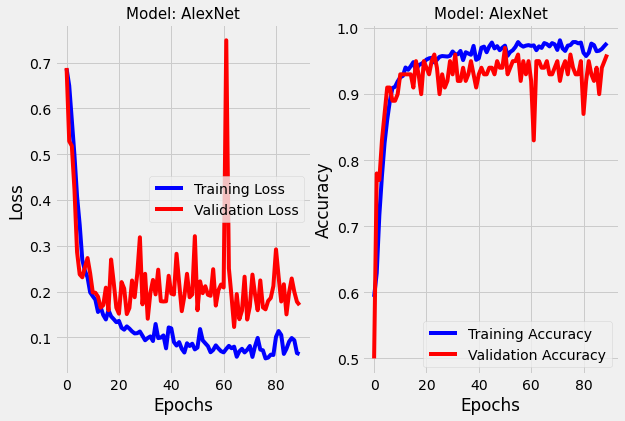

In [20]:
# Plotting learning curve
modelName='AlexNet'
modelSaveName='AlexNet'
saveFig=True
showfigs=True
save_path='./results/'
PlotHistory(history,modelName,modelSaveName,saveFig, save_path, showfigs,DPI);

### Evaluate Model

Let's look at the confusion matrix:

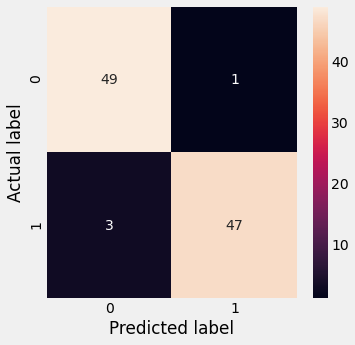

In [21]:
preds=np.argmax(model.predict(test_generator),axis=1)
PlotConfusionMatrix(test_generator.classes, preds,save_fig,save_path,DPI)

We can look at the  mismatched  categories usiong PlotMisMatch:

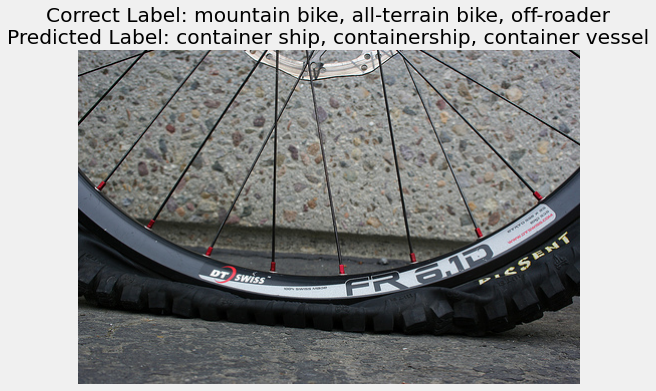

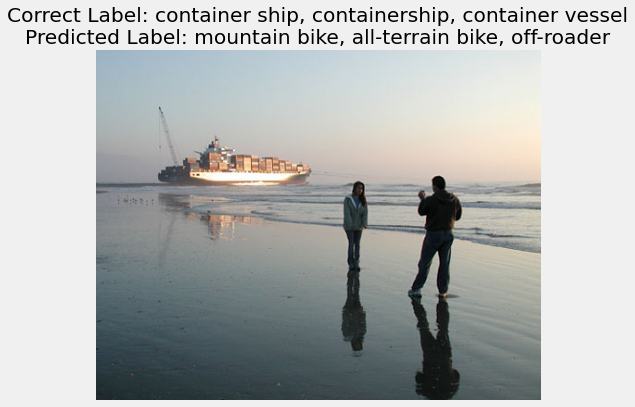

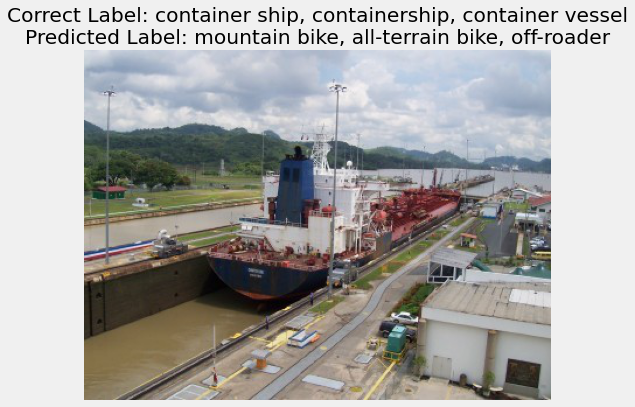

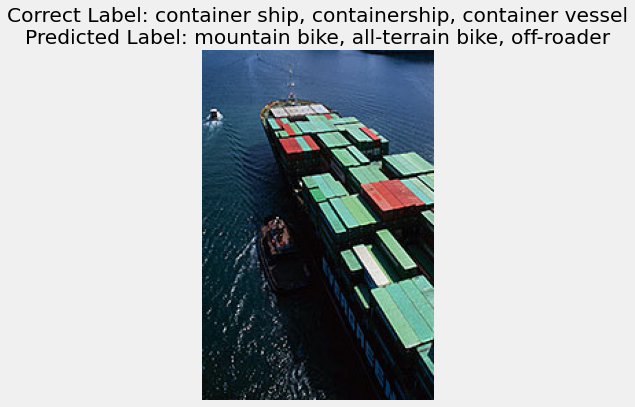

In [22]:
PlotMisMatch(test_generator,preds,validation_directory,Subset,Selected_Classes,cats,save_fig,save_path,DPI)